In [3]:
import matplotlib.pyplot as plt
#Biblioteca para localizar a instalação do Spark no sistema e iniciae o Spark
import findspark
findspark.init()
import pyspark
#Gerenciar sessões do Spark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import pandas as pd
#Funções do Spark SQL
from pyspark.sql.functions import *
#Tipos de dados do Spark SQL,
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp


In [4]:
#Criando uma instância do SparkSession
spark = (pyspark.sql.SparkSession.builder \
        .appName("Tratamento") \
        .getOrCreate())

In [5]:
#Lendo o arquivo csv e retonando um objeto DataFrame
df = spark.read.csv("caso.csv", header=True, encoding='ISO-8859-1',inferSchema=True)
# Converter a coluna "date" para o formato Unix timestamp
df = df.withColumn("date", F.unix_timestamp("date"))
df = df.select([col for col in df.columns if col != 'city'])

In [6]:
df.printSchema()

root
 |-- date: long (nullable = true)
 |-- state: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- order_for_place: integer (nullable = true)
 |-- is_last: boolean (nullable = true)
 |-- estimated_population_2019: integer (nullable = true)
 |-- estimated_population: integer (nullable = true)
 |-- city_ibge_code: integer (nullable = true)
 |-- confirmed_per_100k_inhabitants: double (nullable = true)
 |-- death_rate: double (nullable = true)



In [7]:
df.show(5)

+----------+-----+----------+---------+------+---------------+-------+-------------------------+--------------------+--------------+------------------------------+----------+
|      date|state|place_type|confirmed|deaths|order_for_place|is_last|estimated_population_2019|estimated_population|city_ibge_code|confirmed_per_100k_inhabitants|death_rate|
+----------+-----+----------+---------+------+---------------+-------+-------------------------+--------------------+--------------+------------------------------+----------+
|1648350000|   AP|     state|   160328|  2122|            734|   true|                   845731|              861773|            16|                   18604.43527|    0.0132|
|1648263600|   AP|     state|   160321|  2122|            733|  false|                   845731|              861773|            16|                     18603.623|    0.0132|
|1648177200|   AP|     state|   160314|  2122|            732|  false|                   845731|              861773|        

In [8]:
# Gráfico de barras para casos confirmados por estado
confirmed_by_state = df.groupBy("state").agg(F.sum("confirmed").alias("total_confirmed"))
confirmed_by_state_pd = confirmed_by_state.toPandas()

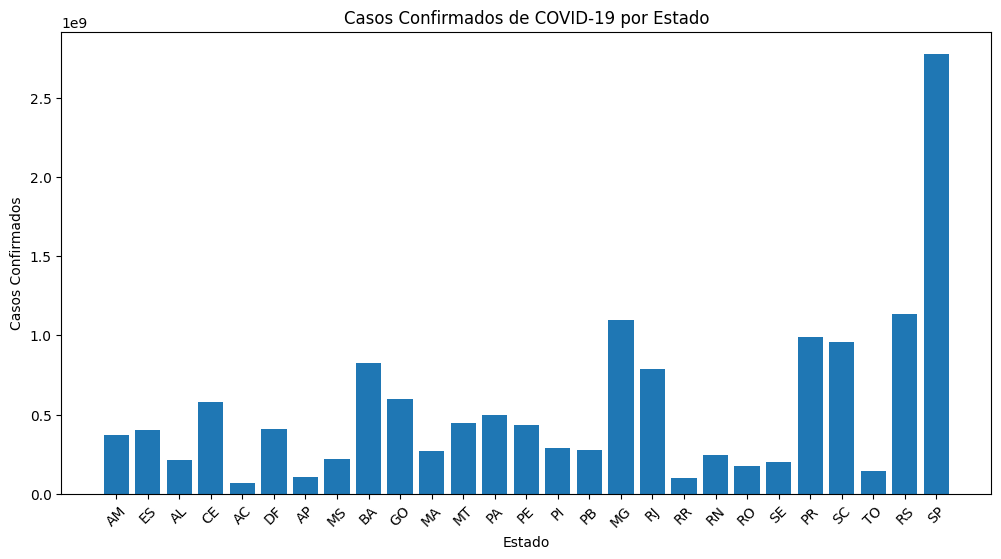

In [9]:
plt.figure(figsize=(12, 6))
plt.bar(confirmed_by_state_pd["state"], confirmed_by_state_pd["total_confirmed"])
plt.xlabel("Estado")
plt.ylabel("Casos Confirmados")
plt.title("Casos Confirmados de COVID-19 por Estado")
plt.xticks(rotation=45)
plt.show()

In [12]:
# Gráfico de linha para acompanhar a evolução dos casos confirmados ao longo do tempo
df_temp = df.groupBy("date").agg(F.sum("confirmed").alias("total_confirmed"))
df_temp_pd = df_temp.toPandas()
# Converter a coluna "date" de Unix timestamp para datetime
df_temp_pd["date"] = pd.to_datetime(df_temp_pd["date"], unit='s')
df_temp_pd.sort_values(by="date", inplace=True)

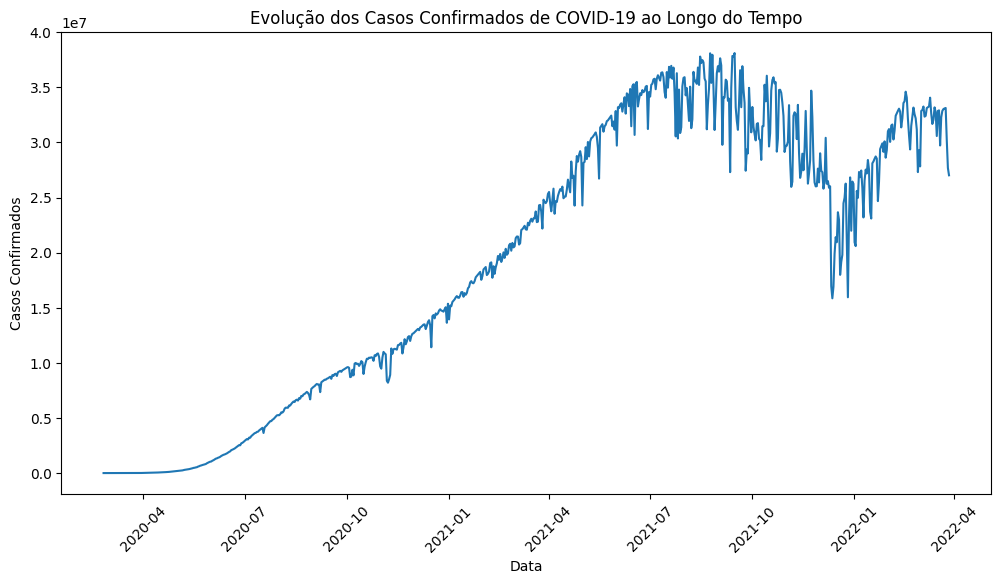

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_temp_pd["date"], df_temp_pd["total_confirmed"])
plt.xlabel("Data")
plt.ylabel("Casos Confirmados")
plt.title("Evolução dos Casos Confirmados de COVID-19 ao Longo do Tempo")
plt.xticks(rotation=45)
plt.show()